#  Deep Learning Project 1 - Image Classifier 

**Instructions on How to Run**  
1. Clone or download this notebook and place it in a working directory.  
2. Ensure you have the following libraries installed:
   - PyTorch
   - torchvision
   - numpy
   - matplotlib
   - PIL
   - tqdm  
3. Download the CIFAR-10 data when prompted.  
4. Run each cell in order (Shift+Enter).  
5. Training checkpoints and logs will be saved under `./outputs`.

## Importing the Necessary Libraries and the Dataset

In [1]:
from __future__ import division

import warnings
from collections import namedtuple
import torch
import torch.nn as nn
from torch.jit.annotations import Optional, Tuple
from torch import Tensor
import os
import numpy as np
import os.path
from glob import glob
from PIL import Image
from tqdm import tqdm
import torchvision.datasets as dset
import torch.utils.data as data
from torchvision import transforms
from ipywidgets import IntProgress
import logging 
import matplotlib.pyplot as plt


## GPU Device Configuration

Check for CUDA and set our device accordingly.

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else: 
    device = 'cpu'

## Setting Hyperparameters

Check for CUDA and set our device accordingly.

In [3]:
learning_rate = 0.01 
batch_train_size = 20 
batch_test_size = 20 
num_epochs = 50

In [4]:
output_dir = "./outputs"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Image Processing 

In [5]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()]) 
test_transform = transforms.Compose([transforms.ToTensor()]) 

## Data Loading & Preparation

In [6]:
train_set = dset.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = data.DataLoader(dataset=train_set, batch_size=batch_train_size, shuffle=True)
test_set = dset.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = data.DataLoader(dataset=test_set, batch_size=batch_test_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Inception Module

In [7]:
class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_1_x, kernel_size=1),
            nn.BatchNorm2d(kernel_1_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_3_in, kernel_size = 1),
            nn.BatchNorm2d(kernel_3_in), 
            nn.ReLU(True), 
            nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(kernel_3_x), 
            nn.ReLU(True)
        )


        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_5_in, kernel_size = 1),
            nn.BatchNorm2d(kernel_5_in), 
            nn.ReLU(True), 
            nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size = 5, padding = 2),
            nn.BatchNorm2d(kernel_5_x), 
            nn.ReLU(True)
        )

        # 3x3 max pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1),
            nn.Conv2d(in_planes, pool_planes, kernel_size = 1),
            nn.BatchNorm2d(pool_planes), 
            nn.ReLU(True)
        )
       

    def forward(self, x):
        return torch.cat([self.b1(x), self.b2(x), self.b3(x), self.b4(x)], dim = 1)
        

## GoogLeNet Module

In [8]:
class Conv(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride = 1, padding = 0):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride = stride, padding = padding)
        self.bn   = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [9]:
class GoogleNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(GoogleNet, self).__init__()
        
        self.conv1 = Conv(in_ch = 3, out_ch = 192, kernel_size = (3,3), padding = 1)
        
        self.inc1 = Inception(in_planes = 192,
                              kernel_1_x = 64,
                              kernel_3_in = 96,
                              kernel_3_x = 128, 
                              kernel_5_in = 16, 
                              kernel_5_x = 32, 
                              pool_planes = 32
                              )
        self.inc2 = Inception(in_planes = 256,
                              kernel_1_x = 128,
                              kernel_3_in = 128,
                              kernel_3_x = 192, 
                              kernel_5_in = 32, 
                              kernel_5_x = 96, 
                              pool_planes = 64
                              )
        
        self.maxpool1 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.inc3 = Inception(in_planes = 480,
                              kernel_1_x = 192,
                              kernel_3_in = 96,
                              kernel_3_x = 208, 
                              kernel_5_in = 16, 
                              kernel_5_x = 48, 
                              pool_planes = 64
                              )

        self.inc4 = Inception(in_planes = 512,
                              kernel_1_x = 160,
                              kernel_3_in = 112,
                              kernel_3_x = 224, 
                              kernel_5_in = 24, 
                              kernel_5_x = 64, 
                              pool_planes = 64
                              )

        self.inc5 = Inception(in_planes = 512,
                              kernel_1_x = 128,
                              kernel_3_in = 128,
                              kernel_3_x = 256, 
                              kernel_5_in = 24, 
                              kernel_5_x = 64, 
                              pool_planes = 64
                              )

        self.inc6 = Inception(in_planes = 512,
                              kernel_1_x = 112,
                              kernel_3_in = 144,
                              kernel_3_x = 288, 
                              kernel_5_in = 32, 
                              kernel_5_x = 64, 
                              pool_planes = 64
                              )

        self.inc7 = Inception(in_planes = 528,
                              kernel_1_x = 256,
                              kernel_3_in = 160,
                              kernel_3_x = 320, 
                              kernel_5_in = 32, 
                              kernel_5_x = 128, 
                              pool_planes = 128
                              )


        self.maxpool2 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.inc8 = Inception(in_planes = 832,
                              kernel_1_x = 256,
                              kernel_3_in = 160,
                              kernel_3_x = 320, 
                              kernel_5_in = 32, 
                              kernel_5_x = 128, 
                              pool_planes = 128
                              )

        self.inc9 = Inception(in_planes = 832,
                              kernel_1_x = 384,
                              kernel_3_in = 192,
                              kernel_3_x = 384, 
                              kernel_5_in = 48, 
                              kernel_5_x = 128, 
                              pool_planes = 128
                              )

        self.avgpool = nn.AvgPool2d(kernel_size = 8, stride = 1)

        self.fc1 = nn.Linear(1024, num_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.inc1(x)
        x = self.inc2(x)
        x = self.maxpool1(x)
        x = self.inc3(x)
        x = self.inc4(x)
        x = self.inc5(x)
        x = self.inc6(x)
        x = self.inc7(x)
        x = self.maxpool2(x)
        x = self.inc8(x)
        x = self.inc9(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        return x
    

## Model, Loss, Optimizer & Scheduler

Instantiate the model, the cross-entropy loss, Adam optimizer, and a LR scheduler.

In [10]:
model = GoogleNet(num_classes=10).to(device)

In [11]:
# Criterion
criterion   = nn.CrossEntropyLoss()

# Optimizer
optimizer   = torch.optim.Adam(model.parameters(), lr = learning_rate)

# Scheduler
scheduler   = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [50, 100], gamma = 0.5)

## Training Function

Defines one epoch of training, returns average loss & accuracy.

In [13]:
def train():
    # Set our network to the training mode.
    model.train()
    
    # Initialize the train loss, total data size, and number corrected predictions.
    train_loss = 0.0
    data_size = 0
    correct_preds = 0
    
    # Put the data to the correct devices using .to()
    for batch_idx, (images, labels) in enumerate(train_loader):
        # Move data to GPU
        images = images.to(device)
        labels = labels.to(device)
    
        # Reset the gradient of the optimzier.
        optimizer.zero_grad()
    
        # Feed the data forward to the Google Net
        outputs = model(images)
    
        # Use the criterion function to compute the loss term
        loss = criterion(outputs, labels)
    
        # Backpropagate the loss
        loss.backward()
    
        # Update the network parameters using the optimizier
        optimizer.step()
    
        # Accumulate the training loss
        train_loss += loss.item() * images.size(0)

        # Find the prediction
        _, preds = outputs.max(dim = 1)
        data_size += labels.size(0)
        correct_preds += preds.eq(labels).sum().item()
    
        # Print average loss and accuracy every 100 epochs
        if batch_idx % 100 == 0:
            avg_loss = train_loss / data_size
            acc = correct_preds / data_size
            print(f"[Train Batch {batch_idx:4d}]  Loss: {avg_loss:.4f}  Acc: {acc:.4f}")
        
    
    epoch_loss = train_loss / data_size
    epoch_acc  = correct_preds / data_size
    
    return epoch_loss, epoch_acc

## Testing Function

Defines one epoch of evaluation under `torch.no_grad()`.

In [14]:
def test():
    # Set our network to the testing (evaluation) mode.
    model.eval()
    
    # Initialize the train loss, total data size, and number corrected predictions.
    test_loss = 0.0
    data_size = 0
    correct_preds = 0
    
    # For each data in the testing split, we warp it using torch.no_grad()
    with torch.no_grad():
        # Put the data to the correct devices using .to()
        for batch_idx, (images, labels) in enumerate(test_loader):
            # Move data to GPU
            images = images.to(device)
            labels = labels.to(device)
        
            # Feed the data forward to the Google Net
            outputs = model(images)
        
            # Use the criterion function to compute the loss term
            loss = criterion(outputs, labels)
        
            # Accumulate the testing loss
            test_loss += loss.item() * images.size(0)
        
            # Find the prediction. hint: using torch.max()
            _, preds = outputs.max(dim = 1)
            data_size += labels.size(0)
            correct_preds += preds.eq(labels).sum().item()
        
            # Print average loss and accuracy every 100 epochs
            if batch_idx % 100 == 0:
                avg_loss = test_loss / data_size
                acc = correct_preds / data_size
                print(f"[Test Batch {batch_idx:4d}]  Loss: {avg_loss:.4f}  Acc: {acc:.4f}")
        
    
    epoch_loss = test_loss / data_size
    epoch_acc  = correct_preds / data_size

    return epoch_loss, epoch_acc

## Epoch (Main Training Loop)

Run for `num_epochs`, log metrics, step the scheduler, and save checkpoints.

In [15]:
train_acc_history = []
test_acc_history  = []
train_loss_history = []
test_loss_history = []

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    train_loss, train_acc = train()
    scheduler.step()
    test_loss,  test_acc  = test()
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)

    print(f"→ Epoch {epoch}: Train Acc={train_acc:.4f}, Test Acc={test_acc:.4f}")

    torch.save(
        model.state_dict(),
        f"{output_dir}/googlenet_epoch{epoch:03d}.pth"
    )



Epoch 1/50
[Train Batch    0]  Loss: 2.4109  Acc: 0.1000
[Train Batch  100]  Loss: 2.4406  Acc: 0.1495
[Train Batch  200]  Loss: 2.2659  Acc: 0.1741
[Train Batch  300]  Loss: 2.1660  Acc: 0.1973
[Train Batch  400]  Loss: 2.1020  Acc: 0.2111
[Train Batch  500]  Loss: 2.0512  Acc: 0.2244
[Train Batch  600]  Loss: 2.0074  Acc: 0.2369
[Train Batch  700]  Loss: 1.9680  Acc: 0.2524
[Train Batch  800]  Loss: 1.9324  Acc: 0.2649
[Train Batch  900]  Loss: 1.9059  Acc: 0.2732
[Train Batch 1000]  Loss: 1.8782  Acc: 0.2829
[Train Batch 1100]  Loss: 1.8600  Acc: 0.2915
[Train Batch 1200]  Loss: 1.8373  Acc: 0.2998
[Train Batch 1300]  Loss: 1.8144  Acc: 0.3091
[Train Batch 1400]  Loss: 1.7932  Acc: 0.3186
[Train Batch 1500]  Loss: 1.7701  Acc: 0.3279
[Train Batch 1600]  Loss: 1.7503  Acc: 0.3363
[Train Batch 1700]  Loss: 1.7335  Acc: 0.3437
[Train Batch 1800]  Loss: 1.7145  Acc: 0.3522
[Train Batch 1900]  Loss: 1.6964  Acc: 0.3594
[Train Batch 2000]  Loss: 1.6795  Acc: 0.3667
[Train Batch 2100]  Lo

# Results Visualization

Plot training vs. validation loss and accuracy curves.

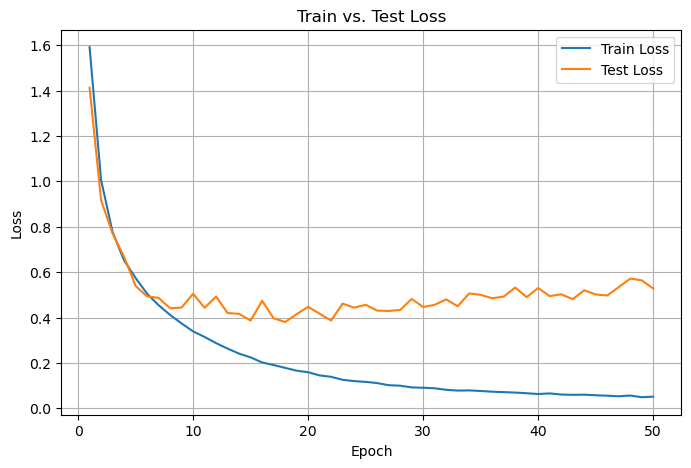

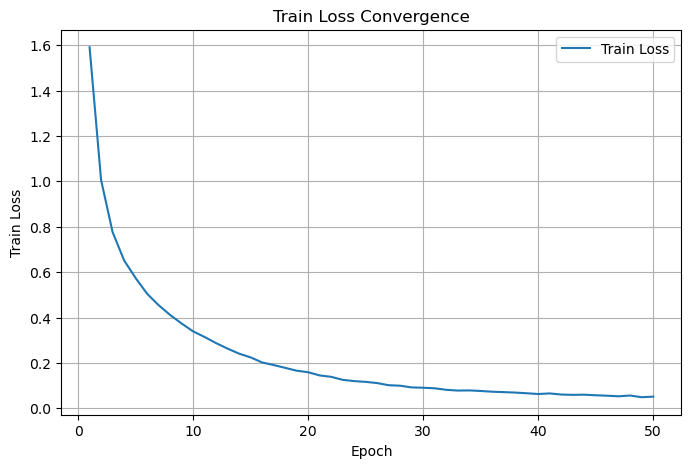

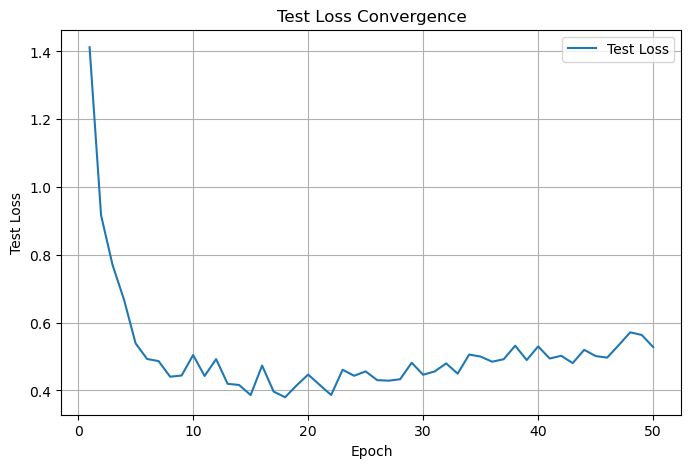

In [16]:
epochs = range(1, num_epochs + 1)

# Combined plot
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss_history, label="Train Loss")
plt.plot(epochs, test_loss_history,  label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs. Test Loss")
plt.legend()
plt.grid(True)
plt.show()

# Train loss only
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss_history, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Train Loss Convergence")
plt.legend()
plt.grid(True)
plt.show()

# Test loss only
plt.figure(figsize=(8,5))
plt.plot(epochs, test_loss_history, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.title("Test Loss Convergence")
plt.legend()
plt.grid(True)
plt.show()

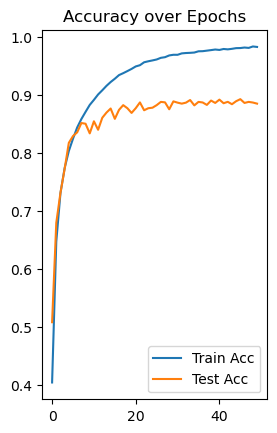

In [18]:
# Accuracy Plot
plt.subplot(1,2,2)
plt.plot(train_acc_history, label='Train Acc')
plt.plot(test_acc_history,  label='Test Acc')
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

# Discussion of Results

### 1. Rapid Early Improvement (Epochs 1–5)
- **Train Accuracy:** Climbed from ~40% to ~80%.  
- **Test Accuracy:** Increased from ~50% to ~82%.  
- **Interpretation:** The model quickly learns low-level features (edges, textures), yielding gains in both training and validation performance.

### 2. Slower Gains & Peak Validation (Epochs 6–20)
- **Train Accuracy:** Rose steadily to ~94%.  
- **Test Accuracy:** Peaked around epochs 15–20 at ~88%.  
- **Interpretation:** The rate of improvement slows as the model captures more complex patterns, and validation performance reaches its maximum.

### 3. Onset of Overfitting (Epochs 21–50)
- **Train Accuracy:** Continues to climb to ~98%.  
- **Test Accuracy:** Fluctuates and trends slightly downward, settling around ~88–89%.  
- **Test Loss:** Reaches minimum between epochs 15–25, then gradually increases, which is a sign of overfitting, where the model begins to memorize noise in the training data.

### 4. Loss Trends
- **Training Loss:** Drops steeply in early epochs, then plateaus as accuracy saturates.  
- **Test Loss:** Mirrors test accuracy, bottoming out mid-training before rising again, which is again a sign of overfitting


# Conclusion

This project demonstrated that a GoogleNet-based CNN can achieve strong image classification performance (≈88% test accuracy) when trained for 15–25 epochs before overfitting sets in. Incorporating early stopping, data augmentation, and stronger regularization narrows the gap between training and evaluation. 
